In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
ray 2.0.0 requires click<=8.0.4,>=7.0, but you have click 8.1.3 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.


In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('brewing coffee', max_images=1)
urls[0]

Searching for 'brewing coffee'


'https://perfectdailygrind.com/wp-content/uploads/2017/08/IMG_20170807_111340_177-e1502286442454.jpg'

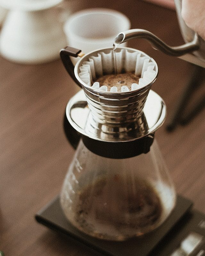

In [5]:
from fastdownload import download_url
dest = 'coffee.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [6]:
searches = 'v60 coffee','aeropress coffee', 'making french press coffee', 'espresso coffee brewing'
path = Path('brewing_method')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    #sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'v60 coffee'
Searching for 'aeropress coffee'
Searching for 'making french press coffee'
Searching for 'espresso coffee brewing'


In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

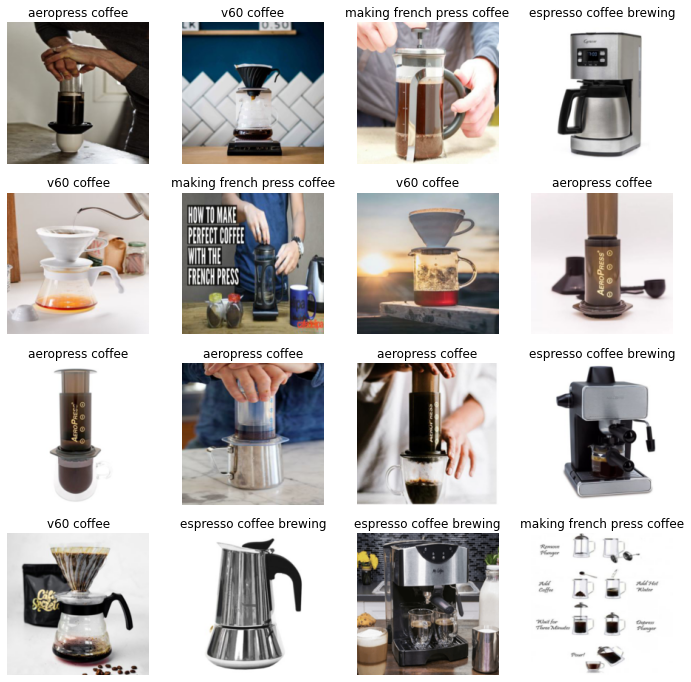

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=16)

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.906731,1.599399,0.521739,00:09


epoch,train_loss,valid_loss,error_rate,time
0,1.188809,1.361335,0.434783,00:01
1,0.830205,1.146860,0.347826,00:01
2,0.617416,0.982119,0.260870,00:01
3,0.483570,0.884293,0.260870,00:01
4,0.383017,0.809508,0.260870,00:01
5,0.316906,0.760954,0.260870,00:01
6,0.264734,0.737781,0.260870,00:01
7,0.225197,0.715801,0.217391,00:01


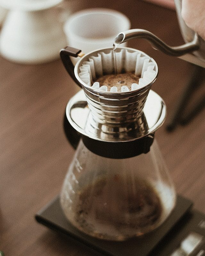

In [10]:
from fastdownload import download_url
dest = 'coffee.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [11]:
coffee_method,_,probs = learn.predict(PILImage.create('coffee.jpg'))
print(f"This is a: {coffee_method}.")
print(f"Probability this is false: {probs[0]:.4f}")

This is a: v60 coffee.
Probability this is false: 0.0012
